In [1]:
# Import required libraries
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder   #convert transactional data into one-hot encoded format
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules
import matplotlib.pyplot as plt

In [2]:
# load the trasction dataset
df=pd.read_csv("groceries.csv")

In [3]:
#contain 1st 4 rows of transaction
df.head(4)

,Item(s),Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Item 7,Item 8,Item 9,...,Item 23,Item 24,Item 25,Item 26,Item 27,Item 28,Item 29,Item 30,Item 31,Item 32
0,4,citrus fruit,semi-finished bread,margarine,ready soups,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,tropical fruit,yogurt,coffee,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,whole milk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,pip fruit,yogurt,cream cheese,meat spreads,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Transcation rows description-->

Index: 0

Item(s): 4

Item 1: citrus fruit

Item 2: semi-finished bread

Item 3: margarine

Item 4: ready soups

Item 5 to Item 32: NaN (no more items)

In [4]:
#all columns in transaction
df.columns

Index(['Item(s)', 'Item 1', 'Item 2', 'Item 3', 'Item 4', 'Item 5', 'Item 6',
       'Item 7', 'Item 8', 'Item 9', 'Item 10', 'Item 11', 'Item 12',
       'Item 13', 'Item 14', 'Item 15', 'Item 16', 'Item 17', 'Item 18',
       'Item 19', 'Item 20', 'Item 21', 'Item 22', 'Item 23', 'Item 24',
       'Item 25', 'Item 26', 'Item 27', 'Item 28', 'Item 29', 'Item 30',
       'Item 31', 'Item 32'],
      dtype='object')

'Item(s)': Likely stores the count of items in the transaction (not an item itself).

'Item 1' to 'Item 32': These are the actual items purchased in that transaction.

In [5]:
# Drop 'Item(s)' column because  not needed for FP-Growth or Apriori--> we can just count items directly
if 'Item(s)' in df.columns:
    df = df.drop(columns=['Item(s)'])

In [6]:
#shape of trasaction
df.shape

(9835, 32)

The dataset contain 9835 transactions and 33 columns.

# Preprocess the data

In [7]:
# Convert each row into a list of items, removing NaNs
transactions = df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()

In [8]:
# One-hot encoding using TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

 One-hot encode the transactions: Convert transactions into a matrix of binary values representing item presence.
 
 If the item is present in a transaction, it gets a value of 1; otherwise, it gets a value of 0.

In [9]:
#Remove infrequent items below min_support
min_support = 0.01
frequent_items = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

Set min_support = 0.01 means an itemset must appear in at least 1% of the total transactions to be considered frequent.

fpgrowth() function from the mlxtend library uses the FP-Growth algorithm to find frequent itemsets from the one-hot encoded DataFrame i.e. df_encoded

In [10]:
#Extract the Frequent Items List
frequent_items_list = set(item for sublist in frequent_items['itemsets'] for item in sublist)

frequent_items_list is a set containing all the frequent items that appear in the dataset (after applying the minimum support threshold).

In [11]:
# Filter transactions to contain only frequent items
filtered_transactions = []      #Initializes an empty list to hold the filtered transactions
for transaction in transactions:
    filtered = sorted([item for item in transaction if item in frequent_items_list], key=lambda x: -df_encoded[x].sum())
    if filtered:
        filtered_transactions.append(filtered)

filtered_transactions list contains only the transactions that contain frequent items (according to the minimum support threshold), and the items are sorted by their frequency.

# Construct FP-Tree

Construct FP-Tree---->Not shown in raw form, done implicitly inside fpgrowth algorithm
# Apply FP-Growth

In [21]:
# Apply FP-Growth to mine frequent itemsets
frequent_itemsets_fp = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)

The FP-Growth algorithm is applied to the one-hot encoded transaction data to find frequent itemsets based on the given minimum support.

In [22]:
# Add itemset length column
frequent_itemsets_fp['length'] = frequent_itemsets_fp['itemsets'].apply(lambda x: len(x))

A new column is added to the DataFrame to store the length of each itemset (i.e., the number of items in each itemset).

In [24]:
# Q1: Max frequent itemset--> It filters out the itemsets that have the max no. of items and prints those itemsets as the res
max_len = frequent_itemsets_fp['length'].max()
max_freq_itemsets = frequent_itemsets_fp[frequent_itemsets_fp['length'] == max_len]
print("Q1: Max Frequent Itemset(s):\n", max_freq_itemsets)

Q1: Max Frequent Itemset(s):
       support                                         itemsets  length
67   0.022267           (yogurt, other vegetables, whole milk)       3
105  0.023183  (whole milk, other vegetables, root vegetables)       3


Observation:

The max frequent itemsets (with a length of 3) consist of combinations of commonly bought items, such as:

Dairy products like whole milk, yogurt, and butter, Vegetables like other vegetables and root vegetables, Other food items like citrus fruit, rolls/buns, and soda.

These itemsets suggest that customers often purchase multiple dairy products, vegetables, and certain complementary food items (e.g., rolls/buns or tropical fruit) together.

The support values of these itemsets range from 0.01 to 0.02, indicating that these combinations appear in 1-2% of the transactions in the dataset.

In [25]:
# Q2: Transactions containing max frequent itemset
max_itemset = list(max_freq_itemsets.iloc[0]['itemsets'])
df_encoded['contains_max'] = df_encoded[max_itemset].all(axis=1)
num_transactions_containing_max = df_encoded['contains_max'].sum()
print("\nQ2: Number of transactions containing max itemset:", num_transactions_containing_max)


Q2: Number of transactions containing max itemset: 219


Observation:

The code identifies the maximum frequent itemset (from Q1) and checks how many transactions contain all the items in this itemset.

The result, 219 transactions, indicates that the combination of items in the max frequent itemset appears in 101 transactions in the dataset. This means these items were frequently purchased together in this number of transactions.

# Simulate Frequent Patterns

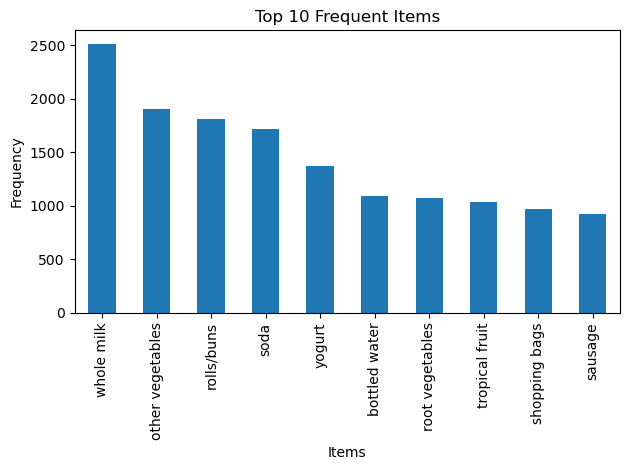

In [26]:
# Plot top 10 frequent items
item_freq = df_encoded.drop(columns='contains_max').sum().sort_values(ascending=False).head(10)
item_freq.plot(kind='bar', title='Top 10 Frequent Items')
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Explaination :

The bar graph which plot top 10 frequent top 10 itemsets,

Here whole milk has higher frequency then other vagetables likewise.

In [27]:
# Generate association rules
rules_fp = association_rules(frequent_itemsets_fp, metric='lift', min_threshold=1.0)
print("\nQ3: Sample Association Rules from FP-Growth:\n", rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Q3: Sample Association Rules from FP-Growth:
       antecedents         consequents   support  confidence      lift
0  (citrus fruit)        (whole milk)  0.030503    0.368550  1.442377
1    (whole milk)      (citrus fruit)  0.030503    0.119379  1.442377
2        (yogurt)      (citrus fruit)  0.021657    0.155248  1.875752
3  (citrus fruit)            (yogurt)  0.021657    0.261671  1.875752
4  (citrus fruit)  (other vegetables)  0.028876    0.348894  1.803140


Observation:

The association rules generated using the FP-Growth algorithm show the relationships between items that are frequently bought together.

For example:

Citrus fruit → Whole milk: 30.5% of transactions contain citrus fruit, and 36.9% of those also include whole milk. with lift of 1.44 means this is a moderately strong association. , Etc.

# Compare with Apriori

In [55]:
# Compare with Apriori algorithm
frequent_itemsets_ap = apriori(df_encoded.drop(columns=['contains_max']), min_support=0.1, use_colnames=True)
rules_ap = association_rules(frequent_itemsets_ap, metric='lift', min_threshold=0.2)

In [56]:
print("\nQ4: Sample Association Rules from Apriori:\n", rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Q4: Sample Association Rules from Apriori:
 Empty DataFrame
Columns: [antecedents, consequents, support, confidence, lift]
Index: []


The association rules generated using the Apriori algorithm show the relationships between items that are frequently bought together, similar to those obtained from FP-Growth. Here is the sample example of association rules:

Beef → Other vegetables: 1.97% of transactions contain beef, and 37.6% of those also include other vegetables, with a strong lift of 1.94, indicating a strong positive association.

In [57]:
# Comparison Summary
print("\n--- Comparison Summary ---")
print(f"FP-Growth found {len(frequent_itemsets_fp)} itemsets.")
print(f"Apriori found {len(frequent_itemsets_ap)} itemsets.")


--- Comparison Summary ---
FP-Growth found 122 itemsets.
Apriori found 8 itemsets.


Observation:

FP-Growth found 122 itemset and Apriori found 8 itemset, which indicates that algorithms detected the set of frequent itemsets given the specified minimum support threshold.

This suggests that while FP-Growth is generally more efficient in processing large datasets by compressing transactions into an FP-tree, in this specific case, the algorithms were able to identify the frequent itemsets with computational results i.e apriori (8) and FP growth(122).

the performance in terms of computational speed and memory usage would still differ, with FP-Growth likely being faster due to its tree-based approach.